# TabPFN on Relational Databases: Single-Table vs. Merged-Table Benchmark

This notebook evaluates **TabPFN** on **real-world relational datasets** in two scenarios:

1. **Single-table**: apply TabPFN on a single table (no joins).
2. **Merged-table**: join relevant tables to create a feature-rich table and apply TabPFN.

**Datasets (real-world, public):**
- **MovieLens 100k** (ratings + users + items)
- **Northwind** (classic sample commerce DB, SQLite)
- **Chinook** (digital media store DB, SQLite)
- **Sakila** (DVD rental sample DB, SQLite)

**Metrics (classification & regression):**
- Classification: `accuracy`, `roc_auc`, `f1_macro`, plus `fit_time`, `predict_time`
- Regression: `mae`, `mse`, plus `fit_time`, `predict_time`

> Notes
> - TabPFN is optimized for small-to-medium datasets and benefits from GPU. On CPU, keep sample sizes modest.
> - If any dataset download fails, **manually place** the files into `DATA_DIR` as instructed below and re-run the corresponding loader cell.


## 0. Environment Setup

In [45]:

# If running locally, you may uncomment installs as needed.
# !pip install -U pip
# !pip install -U tabpfn scikit-learn pandas numpy pyarrow matplotlib requests zipfile36 sqlalchemy sqlite3-binary
# Optional: TabPFN extensions for ensembling (can be slow):
# !pip install git+https://github.com/PriorLabs/tabpfn-extensions.git

import os
import time
import math
import zipfile
import io
import sys
import shutil
import sqlite3
import pathlib
import warnings
from typing import Tuple, Dict, Any, List

import numpy as np
import pandas as pd
import requests

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder

# TabPFN imports
from tabpfn import TabPFNClassifier, TabPFNRegressor

# Optional: set model cache dir if needed
# os.environ['TABPFN_MODEL_CACHE_DIR'] = '/path/to/tabpfn_models'

pd.set_option('display.max_columns', 120)
DATA_DIR = pathlib.Path('data_relational_benchmark').resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)
print('DATA_DIR =', DATA_DIR)


DATA_DIR = /Users/michaelflppv/PycharmProjects/TabPFN/test_performance/data_relational_benchmark


## 1. Utilities

In [46]:

def safe_request(url: str, dest: pathlib.Path, binary: bool = True, timeout: int = 60) -> bool:
    try:
        r = requests.get(url, timeout=timeout)
        if r.status_code == 200:
            mode = 'wb' if binary else 'w'
            with open(dest, mode) as f:
                f.write(r.content if binary else r.text)
            return True
        else:
            print(f"[WARN] HTTP {r.status_code} for {url}")
            return False
    except Exception as e:
        print(f"[WARN] Download failed for {url}: {e}")
        return False

def label_encode_df(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    encoders = {}
    df_enc = df.copy()
    for col in df_enc.columns:
        if df_enc[col].dtype == 'object' or str(df_enc[col].dtype).startswith('category'):
            try:
                # Try converting to string, skip if UnicodeDecodeError or similar occurs
                df_enc[col] = df_enc[col].astype(str).fillna('NA')
                df_enc[col] = LabelEncoder().fit_transform(df_enc[col])
                encoders[col] = True
            except Exception as e:
                warnings.warn(f"Skipping column '{col}' in label encoding due to: {e}")
                df_enc.drop(columns=[col], inplace=True)
    return df_enc, encoders

MAX_ROWS = 2000  # Limit usage to 2000 rows per dataset

def train_eval_classifier(X: pd.DataFrame, y: pd.Series, label: str, test_size: float = 0.25, random_state: int = 42, device: str = None) -> Dict[str, Any]:
    # Limit rows to MAX_ROWS
    if X.shape[0] > MAX_ROWS:
        X = X.sample(n=MAX_ROWS, random_state=random_state)
        y = y.loc[X.index]
    X_enc, _ = label_encode_df(X)
    y = y.astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=test_size, random_state=random_state, stratify=y)
    clf = TabPFNClassifier(device=device, ignore_pretraining_limits=True) if device else TabPFNClassifier(ignore_pretraining_limits=True)
    t0 = time.perf_counter()
    clf.fit(X_train, y_train)
    fit_time = time.perf_counter() - t0

    t1 = time.perf_counter()
    y_pred = clf.predict(X_test)
    pred_time = time.perf_counter() - t1

    metrics = {
        'setting': label,
        'task': 'classification',
        'accuracy': float(accuracy_score(y_test, y_pred)),
        'roc_auc': None,
        'f1_macro': float(f1_score(y_test, y_pred, average='macro')),
        'mae': None,
        'mse': None,
        'fit_time': fit_time,
        'predict_time': pred_time,
        'n_train': int(X_train.shape[0]),
        'n_test': int(X_test.shape[0]),
        'n_features': int(X_train.shape[1])
    }

    # ROC AUC only for binary classification with proba available
    try:
        if len(np.unique(y)) == 2:
            y_proba = clf.predict_proba(X_test)
            if y_proba.shape[1] == 2:
                metrics['roc_auc'] = float(roc_auc_score(y_test, y_proba[:, 1]))
    except Exception as e:
        print("[WARN] ROC AUC failed:", e)

    return metrics

def train_eval_regressor(X: pd.DataFrame, y: pd.Series, label: str, test_size: float = 0.25, random_state: int = 42, device: str = None) -> Dict[str, Any]:
    # Limit rows to MAX_ROWS
    if X.shape[0] > MAX_ROWS:
        X = X.sample(n=MAX_ROWS, random_state=random_state)
        y = y.loc[X.index]
    X_enc, _ = label_encode_df(X)
    y = pd.to_numeric(y, errors='coerce')
    ok = y.notna()
    X_enc, y = X_enc.loc[ok], y.loc[ok]
    X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=test_size, random_state=random_state)
    reg = TabPFNRegressor(device=device, ignore_pretraining_limits=True) if device else TabPFNRegressor(ignore_pretraining_limits=True)
    t0 = time.perf_counter()
    reg.fit(X_train, y_train)
    fit_time = time.perf_counter() - t0

    t1 = time.perf_counter()
    y_pred = reg.predict(X_test)
    pred_time = time.perf_counter() - t1

    return {
        'setting': label,
        'task': 'regression',
        'accuracy': None,
        'roc_auc': None,
        'f1_macro': None,
        'mae': float(mean_absolute_error(y_test, y_pred)),
        'mse': float(mean_squared_error(y_test, y_pred)),
        'fit_time': fit_time,
        'predict_time': pred_time,
        'n_train': int(X_train.shape[0]),
        'n_test': int(X_test.shape[0]),
        'n_features': int(X_train.shape[1])
    }


## 2. Dataset Loaders (download or local files)
Each loader returns a dictionary with `singles` and `merged` entries.

### 2.1 MovieLens 100k

In [47]:

def load_movielens_100k(data_dir: pathlib.Path) -> Dict[str, Any]:
    root = data_dir / "ml-100k"
    zip_path = data_dir / "ml-100k.zip"
    if not root.exists():
        url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
        ok = safe_request(url, zip_path)
        if ok:
            with zipfile.ZipFile(zip_path, 'r') as zf:
                zf.extractall(data_dir)
        else:
            raise RuntimeError("MovieLens 100k not available. Place 'ml-100k' folder under DATA_DIR.")
    # Load core tables
    ratings = pd.read_csv(root / "u.data", sep="\t", names=["user_id","item_id","rating","timestamp"], engine="python")
    users = pd.read_csv(root / "u.user", sep="\|", names=["user_id","age","gender","occupation","zip"], engine="python")
    items = pd.read_csv(root / "u.item", sep="\|", encoding="latin-1", header=None,
                        names=["item_id","title","release_date","video_release_date","IMDb_URL","unknown","Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"], engine="python")

    # Single-table task (ratings only): predict binary 'like' (rating >= 4)
    single = ratings.copy()
    single['like'] = (single['rating'] >= 4).astype(int)
    X_single = single[['user_id','item_id','timestamp']]
    y_single = single['like']

    # Merged-table: join users+items to ratings
    merged = ratings.merge(users, on='user_id', how='left').merge(items.drop(columns=['title','IMDb_URL','video_release_date']), on='item_id', how='left')
    merged['like'] = (merged['rating'] >= 4).astype(int)
    # For regression we also try to predict the numeric rating
    X_merged = merged.drop(columns=['rating','like'])
    y_like = merged['like']
    y_rating = merged['rating']

    return {
        "name": "movielens_100k",
        "singles": [
            (X_single, y_single, "ML-100k_single_like_cls")
        ],
        "merged": (X_merged, y_like, "ML-100k_merged_like_cls"),
        "merged_reg": (X_merged, y_rating, "ML-100k_merged_rating_reg")
    }

mv = load_movielens_100k(DATA_DIR)
{ k: type(v) for k,v in mv.items() if k!='singles' }


{'name': str, 'merged': tuple, 'merged_reg': tuple}

### 2.2 Northwind (SQLite)

In [48]:

def load_northwind(data_dir: pathlib.Path) -> Dict[str, Any]:
    db_path = data_dir / "northwind.sqlite"
    if not db_path.exists():
        # Several mirrors exist; try a commonly used one. If it fails, user must place the file manually.
        urls = [
            "https://github.com/jpwhite3/northwind-SQLite3/raw/master/Northwind_large.sqlite",
            "https://raw.githubusercontent.com/jpwhite3/northwind-SQLite3/master/Northwind_small.sqlite"
        ]
        ok_any = False
        for url in urls:
            ok_any = safe_request(url, db_path)
            if ok_any:
                break
        if not ok_any:
            raise RuntimeError("Northwind SQLite not available. Place a northwind .sqlite file under DATA_DIR as 'northwind.sqlite'.")

    con = sqlite3.connect(str(db_path))
    orders = pd.read_sql_query("SELECT * FROM Orders;", con)
    customers = pd.read_sql_query("SELECT * FROM Customers;", con)
    shippers = pd.read_sql_query("SELECT * FROM Shippers;", con)
    order_details = pd.read_sql_query("SELECT * FROM 'Order Details';", con)

    # Single-table: Orders -> classify HighFreight (above median) and regress Freight
    orders_single = orders.copy()
    median_freight = orders_single['Freight'].median()
    orders_single['HighFreight'] = (orders_single['Freight'] >= median_freight).astype(int)
    X_single_cls = orders_single.drop(columns=['HighFreight'])
    y_single_cls = orders_single['HighFreight']
    X_single_reg = orders_single.drop(columns=[])
    y_single_reg = orders_single['Freight']

    # Merged: Orders + Customers + Shippers + aggregated order_details
    od_agg = order_details.groupby('OrderID').agg(
        ItemsCount=('ProductID','count'),
        SumExtendedPrice=('UnitPrice', lambda s: float((s * order_details.loc[s.index, 'Quantity']).sum())),
        SumDiscount=('Discount','sum')
    ).reset_index()
    merged = orders.merge(customers, on='CustomerID', how='left').merge(shippers, on='ShipVia', how='left').merge(od_agg, left_on='OrderID', right_on='OrderID', how='left')
    merged['HighFreight'] = (merged['Freight'] >= merged['Freight'].median()).astype(int)

    X_merged_cls = merged.drop(columns=['HighFreight'])
    y_merged_cls = merged['HighFreight']
    X_merged_reg = merged.drop(columns=[])
    y_merged_reg = merged['Freight']

    con.close()
    return {
        "name": "northwind",
        "singles": [
            (X_single_cls, y_single_cls, "Northwind_single_highfreight_cls")
        ],
        "singles_reg": (X_single_reg.drop(columns=['Freight']), y_single_reg, "Northwind_single_freight_reg"),
        "merged": (X_merged_cls, y_merged_cls, "Northwind_merged_highfreight_cls"),
        "merged_reg": (X_merged_reg.drop(columns=['Freight']), y_merged_reg, "Northwind_merged_freight_reg")
    }

# nw = load_northwind(DATA_DIR)
# { k: isinstance(nw.get(k), tuple) for k in ['merged','merged_reg'] }


### 2.3 Chinook (SQLite)

In [49]:

def load_chinook(data_dir: pathlib.Path) -> Dict[str, Any]:
    db_path = data_dir / "chinook.sqlite"
    if not db_path.exists():
        urls = [
            "https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite",
            "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite_AutoIncrementPKs.sqlite"
        ]
        ok_any = False
        for url in urls:
            ok_any = safe_request(url, db_path)
            if ok_any:
                break
        if not ok_any:
            raise RuntimeError("Chinook SQLite not available. Place as 'chinook.sqlite' under DATA_DIR.")
    con = sqlite3.connect(str(db_path))
    invoices = pd.read_sql_query("SELECT * FROM Invoice;", con)
    invoice_items = pd.read_sql_query("SELECT * FROM InvoiceLine;", con)
    customers = pd.read_sql_query("SELECT * FROM Customer;", con)
    employees = pd.read_sql_query("SELECT * FROM Employee;", con)

    # Single-table: Invoice -> classify HighTotal and regress Total
    inv_single = invoices.copy()
    inv_single['HighTotal'] = (inv_single['Total'] >= inv_single['Total'].median()).astype(int)
    X_single_cls = inv_single.drop(columns=['HighTotal'])
    y_single_cls = inv_single['HighTotal']
    X_single_reg = inv_single.drop(columns=['Total'])
    y_single_reg = inv_single['Total']

    # Merged: Invoice + Customer + Employee (support) + aggregated invoice_items
    ii_agg = invoice_items.groupby('InvoiceId').agg(
        ItemsCount=('TrackId','count'),
        SumUnitPrice=('UnitPrice','sum'),
        SumQuantity=('Quantity','sum')
    ).reset_index().rename(columns={'InvoiceId':'InvoiceId'})
    merged = invoices.merge(customers, on='CustomerId', how='left').merge(employees, left_on='SupportRepId', right_on='EmployeeId', how='left').merge(ii_agg, left_on='InvoiceId', right_on='InvoiceId', how='left')
    merged['HighTotal'] = (merged['Total'] >= merged['Total'].median()).astype(int)

    X_merged_cls = merged.drop(columns=['HighTotal'])
    y_merged_cls = merged['HighTotal']
    X_merged_reg = merged.drop(columns=['Total'])
    y_merged_reg = merged['Total']

    con.close()
    return {
        "name": "chinook",
        "singles": [
            (X_single_cls, y_single_cls, "Chinook_single_hightotal_cls")
        ],
        "singles_reg": (X_single_reg, y_single_reg, "Chinook_single_total_reg"),
        "merged": (X_merged_cls, y_merged_cls, "Chinook_merged_hightotal_cls"),
        "merged_reg": (X_merged_reg, y_merged_reg, "Chinook_merged_total_reg")
    }

# ck = load_chinook(DATA_DIR)
# { k: isinstance(ck.get(k), tuple) for k in ['merged','merged_reg'] }


### 2.4 Sakila (SQLite)

In [50]:

def load_sakila(data_dir: pathlib.Path) -> Dict[str, Any]:
    db_path = data_dir / "sakila.sqlite"
    if not db_path.exists():
        urls = [
            "https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/sakila.sqlite",  # placeholder (may 404)
            "https://github.com/jpwhite3/sqlite-sakila/raw/master/sakila.db"
        ]
        ok_any = False
        for url in urls:
            ok_any = safe_request(url, db_path)
            if ok_any:
                break
        if not ok_any:
            raise RuntimeError("Sakila SQLite not available. Place as 'sakila.sqlite' or 'sakila.sqlite' under DATA_DIR (rename to sakila.sqlite).")
    # Some mirrors provide 'sakila.sqlite'; ensure extension doesn't thwart sqlite
    if not db_path.exists() and (data_dir / "sakila.sqlite").exists():
        shutil.copy(data_dir / "sakila.sqlite", db_path)

    con = sqlite3.connect(str(db_path))
    # rental, payment, customer, staff
    try:
        rental = pd.read_sql_query("SELECT * FROM rental;", con)
        payment = pd.read_sql_query("SELECT * FROM payment;", con)
        customer = pd.read_sql_query("SELECT * FROM customer;", con)
        staff = pd.read_sql_query("SELECT * FROM staff;", con)
    except Exception as e:
        con.close()
        raise RuntimeError(f"Sakila schema unexpected: {e}")

    # Single-table: payment -> classify HighAmount and regress amount
    pay_single = payment.copy()
    pay_single['HighAmount'] = (pay_single['amount'] >= pay_single['amount'].median()).astype(int)
    X_single_cls = pay_single.drop(columns=['HighAmount'])
    y_single_cls = pay_single['HighAmount']
    X_single_reg = pay_single.drop(columns=['amount'])
    y_single_reg = pay_single['amount']

    # Merged: payment + customer + staff + rental aggregated (by customer / staff and time)
    r_agg = rental.groupby('customer_id').agg(
        Rentals=('rental_id','count')
    ).reset_index()
    merged = payment.merge(customer, on='customer_id', how='left').merge(staff, on='staff_id', how='left').merge(r_agg, on='customer_id', how='left')
    merged['HighAmount'] = (merged['amount'] >= merged['amount'].median()).astype(int)

    X_merged_cls = merged.drop(columns=['HighAmount'])
    y_merged_cls = merged['HighAmount']
    X_merged_reg = merged.drop(columns=['amount'])
    y_merged_reg = merged['amount']

    con.close()
    return {
        "name": "sakila",
        "singles": [
            (X_single_cls, y_single_cls, "Sakila_single_highamount_cls")
        ],
        "singles_reg": (X_single_reg, y_single_reg, "Sakila_single_amount_reg"),
        "merged": (X_merged_cls, y_merged_cls, "Sakila_merged_highamount_cls"),
        "merged_reg": (X_merged_reg, y_merged_reg, "Sakila_merged_amount_reg")
    }

# sk = load_sakila(DATA_DIR)
# { k: isinstance(sk.get(k), tuple) for k in ['merged','merged_reg'] }


## 3. Build Benchmark Suite

In [51]:

def build_datasets():
    datasets = []
    errors = []

    # Add MovieLens 100k
    try:
        datasets.append(load_movielens_100k(DATA_DIR))
    except Exception as e:
        errors.append(("load_movielens_100k", str(e)))

    # Add Northwind
    try:
        datasets.append(load_northwind(DATA_DIR))
    except Exception as e:
        errors.append(("load_northwind", str(e)))

    # Add Chinook
    try:
        datasets.append(load_chinook(DATA_DIR))
    except Exception as e:
        errors.append(("load_chinook", str(e)))

    # Add Sakila
    try:
        datasets.append(load_sakila(DATA_DIR))
    except Exception as e:
        errors.append(("load_sakila", str(e)))

    if errors:
        print("[WARN] Some loaders failed. Please review messages and place files manually if needed:")
        for name, msg in errors:
            print(f"  - {name}: {msg}")

    if len(datasets) == 0:
        raise RuntimeError(
            "No datasets available. Ensure internet access for first run, "
            "or pre-populate DATA_DIR with the expected files."
        )
    return datasets

datasets = build_datasets()
len(datasets), [d['name'] for d in datasets]


[WARN] Some loaders failed. Please review messages and place files manually if needed:
  - load_northwind: 'ShipVia'


(3, ['movielens_100k', 'chinook', 'sakila'])

## 4. Run Experiments
We evaluate both classification and regression tasks where defined for each dataset.

In [52]:

results = []

def maybe_run_cls(entry):
    if entry is None: 
        return
    X, y, lbl = entry
    # Limit rows to MAX_ROWS
    if X.shape[0] > MAX_ROWS:
        X = X.sample(n=MAX_ROWS, random_state=42)
        y = y.loc[X.index]
    res = train_eval_classifier(X, y, lbl)
    results.append(res)

def maybe_run_reg(entry):
    if entry is None: 
        return
    X, y, lbl = entry
    # Limit rows to MAX_ROWS
    if X.shape[0] > MAX_ROWS:
        X = X.sample(n=MAX_ROWS, random_state=42)
        y = y.loc[X.index]
    res = train_eval_regressor(X, y, lbl)
    results.append(res)

for d in datasets:
    # single classification tasks
    for X, y, lbl in d.get("singles", []):
        maybe_run_cls((X, y, lbl))
    # merged classification
    if d.get("merged"):
        maybe_run_cls(d.get("merged"))
    # regression tasks if available
    if d.get("singles_reg"):
        maybe_run_reg(d.get("singles_reg"))
    if d.get("merged_reg"):
        maybe_run_reg(d.get("merged_reg"))

pd.DataFrame(results).head()


/var/folders/yl/k2ptpp6s2ms3m1kvq65cr07m0000gn/T/ipykernel_6195/4112156123.py:27: UserWarning: Skipping column 'picture' in label encoding due to: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
  warnings.warn(f"Skipping column '{col}' in label encoding due to: {e}")
/var/folders/yl/k2ptpp6s2ms3m1kvq65cr07m0000gn/T/ipykernel_6195/4112156123.py:27: UserWarning: Skipping column 'picture' in label encoding due to: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
  warnings.warn(f"Skipping column '{col}' in label encoding due to: {e}")


,setting,task,accuracy,roc_auc,f1_macro,mae,mse,fit_time,predict_time,n_train,n_test,n_features
0,ML-100k_single_like_cls,classification,0.590,0.606401,0.564495,NaN,NaN,0.077044,3.727259,1500,500,3
1,ML-100k_merged_like_cls,classification,0.604,0.615710,0.591928,NaN,NaN,0.079991,15.445270,1500,500,27
2,ML-100k_merged_rating_reg,regression,NaN,NaN,NaN,0.846012,1.180385,0.189829,11.126292,1500,500,27
3,Chinook_single_hightotal_cls,classification,1.000,1.000000,1.000000,NaN,NaN,0.070177,0.569136,309,103,9
4,Chinook_merged_hightotal_cls,classification,1.000,1.000000,1.000000,NaN,NaN,0.068476,1.141684,309,103,39


## 5. Aggregate & Visualize Results

,setting,task,accuracy,roc_auc,f1_macro,mae,mse,fit_time,predict_time,n_train,n_test,n_features,dataset
0,Chinook_merged_hightotal_cls,classification,1.000,1.000000,1.000000,NaN,NaN,0.068476,1.141684,309,103,39,Chinook
1,Chinook_single_hightotal_cls,classification,1.000,1.000000,1.000000,NaN,NaN,0.070177,0.569136,309,103,9,Chinook
2,Chinook_merged_total_reg,regression,NaN,NaN,NaN,0.013841,0.005807,0.143750,16.901148,309,103,39,Chinook
3,Chinook_single_total_reg,regression,NaN,NaN,NaN,2.265141,10.993108,0.112737,1.157490,309,103,9,Chinook
4,ML-100k_merged_like_cls,classification,0.604,0.615710,0.591928,NaN,NaN,0.079991,15.445270,1500,500,27,ML-100k
5,ML-100k_single_like_cls,classification,0.590,0.606401,0.564495,NaN,NaN,0.077044,3.727259,1500,500,3,ML-100k
6,ML-100k_merged_rating_reg,regression,NaN,NaN,NaN,0.846012,1.180385,0.189829,11.126292,1500,500,27,ML-100k
7,Sakila_merged_highamount_cls,classification,0.998,1.000000,0.997976,NaN,NaN,0.088300,8.882519,1500,500,25,Sakila
8,Sakila_single_highamount_cls,classification,1.000,1.000000,1.000000,NaN,NaN,0.090649,3.650564,1500,500,7,Sakila
9,Sakila_merged_amount_reg,regression,NaN,NaN,NaN,1.114554,1.827404,0.340787,10.831823,1500,500,25,Sakila


Saved results to: /Users/michaelflppv/PycharmProjects/TabPFN/test_performance/data_relational_benchmark/tabpfn_relational_benchmark_results_1755025028.csv


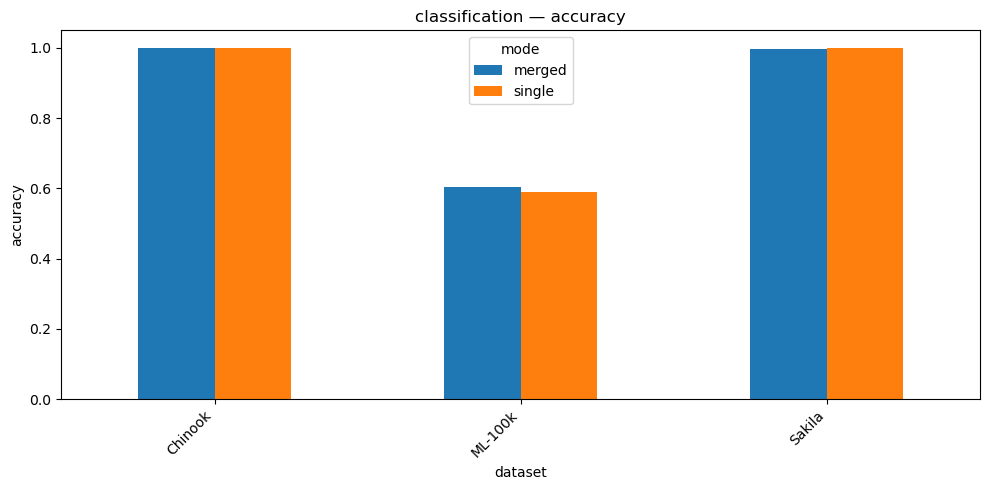

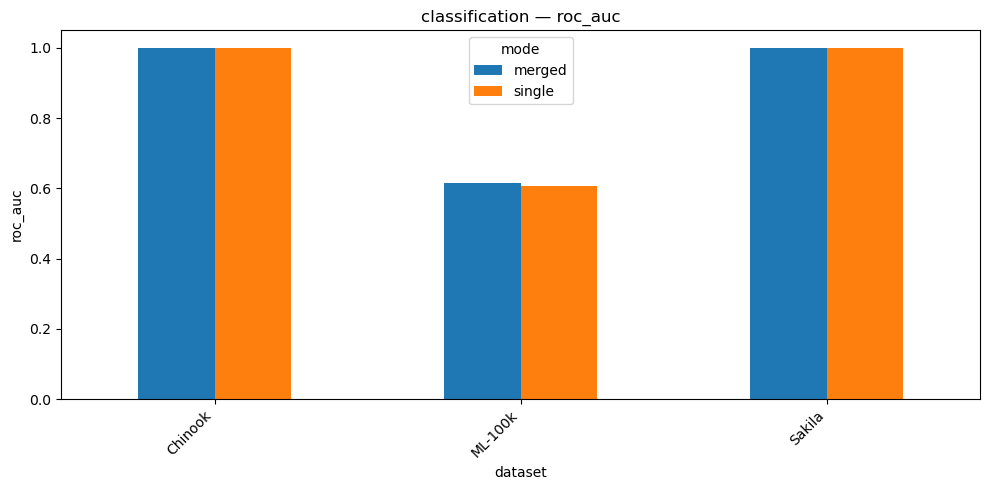

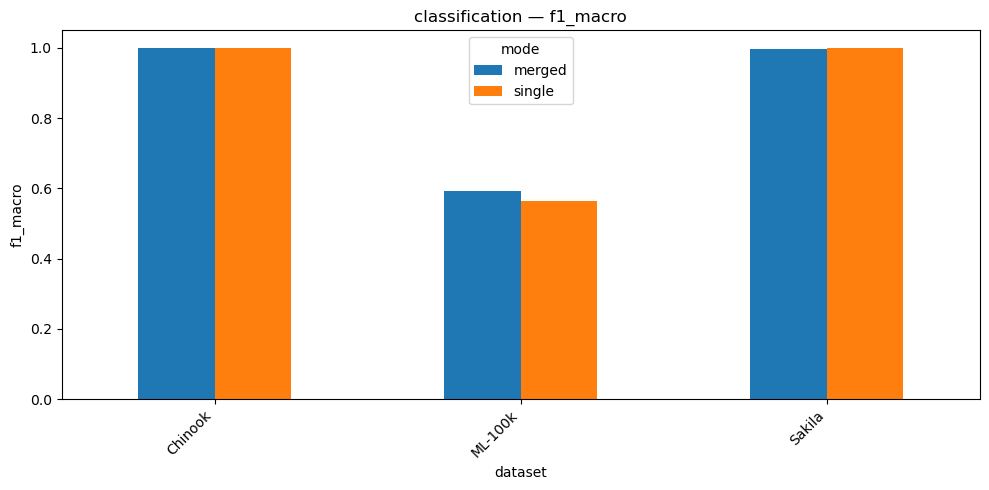

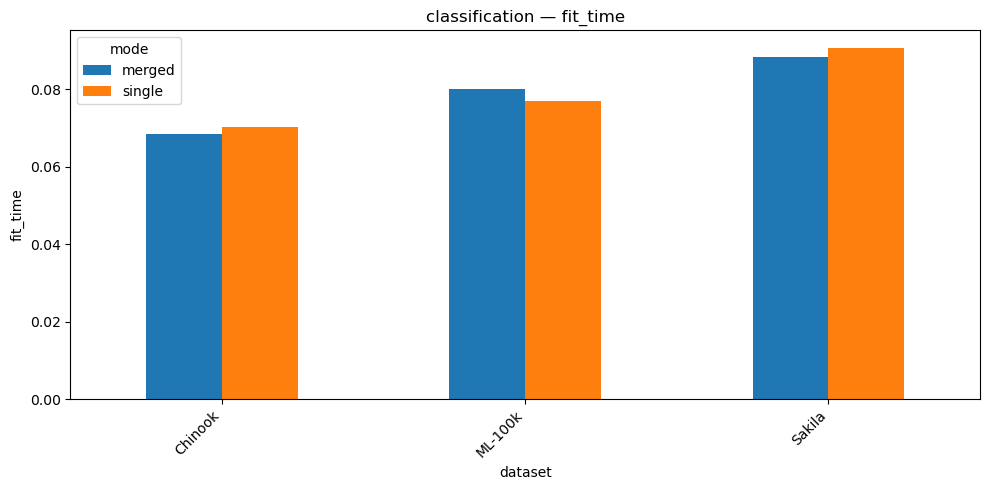

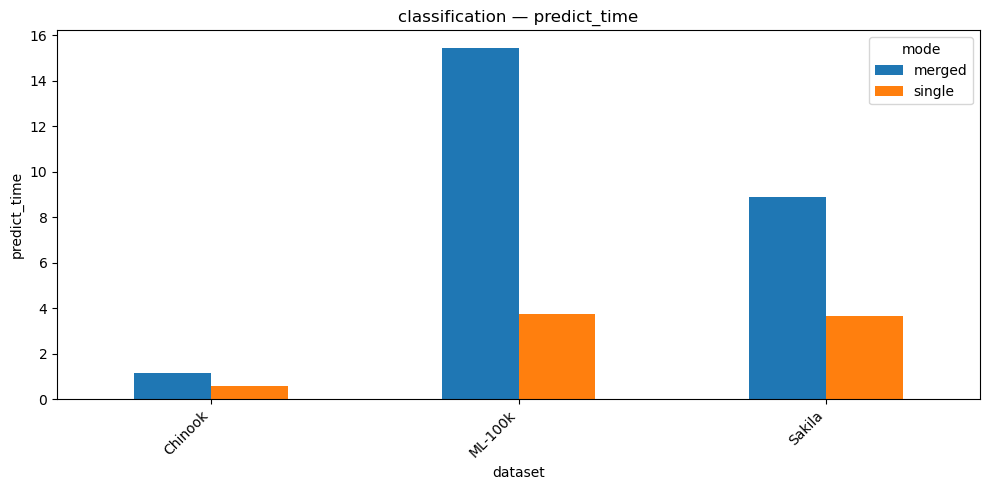

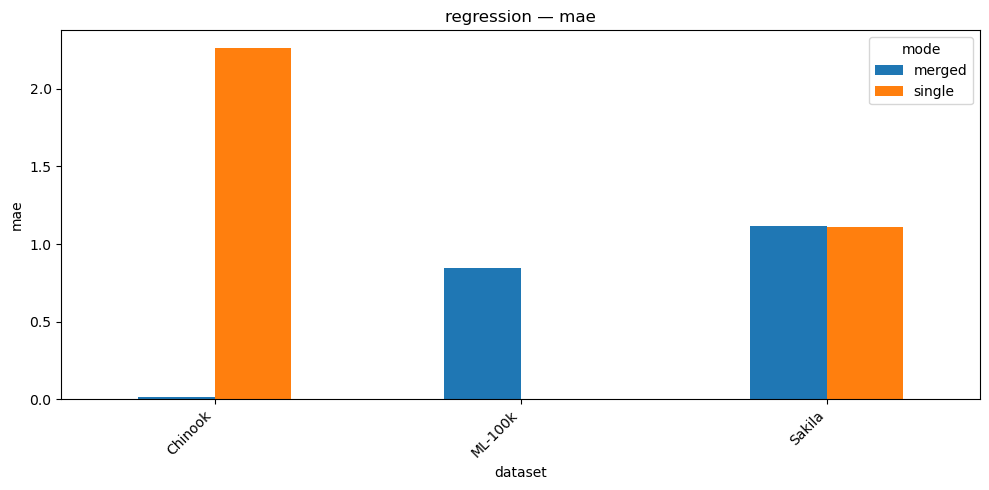

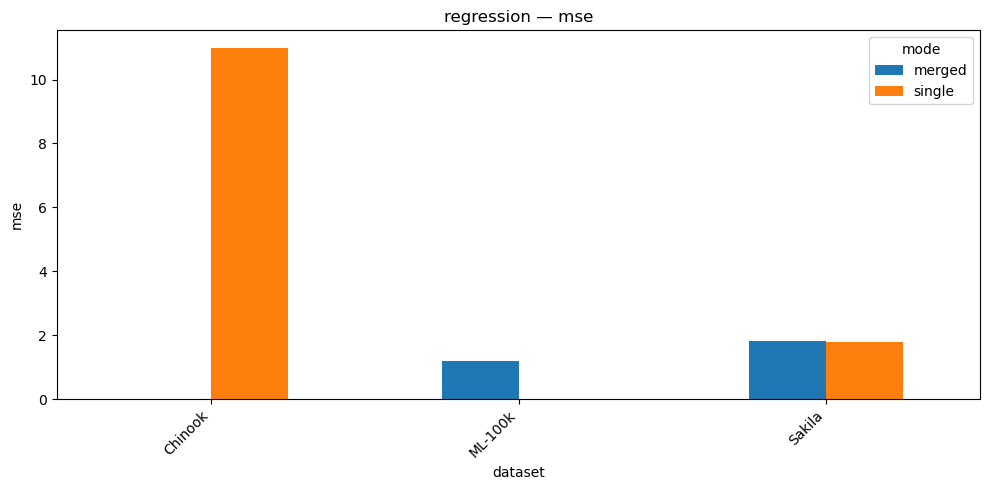

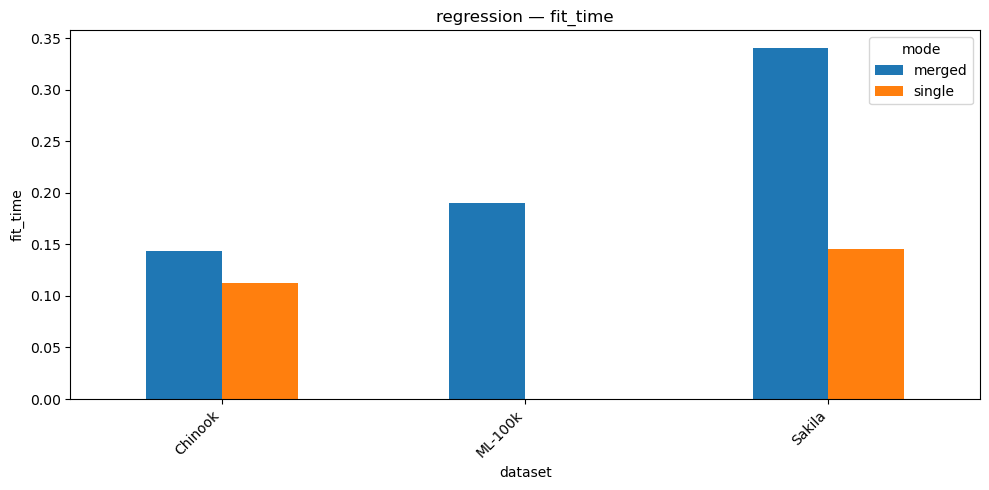

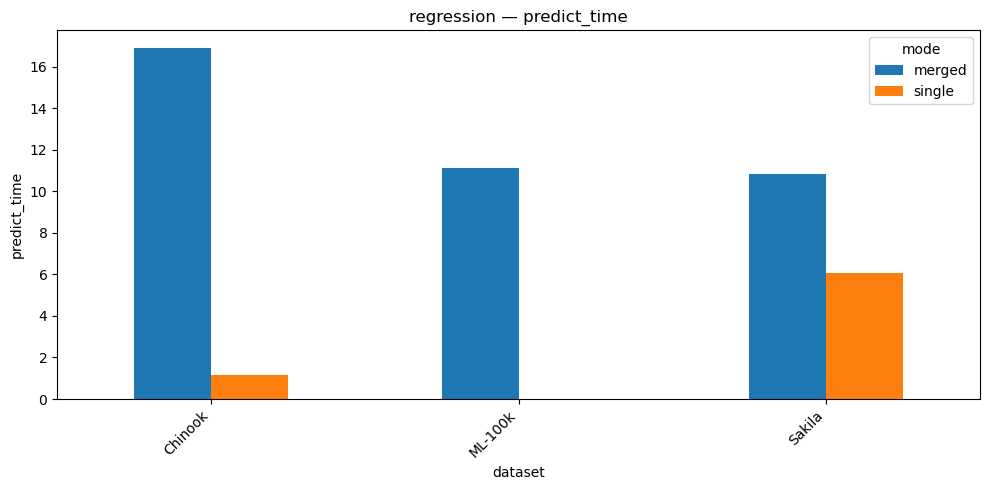

In [53]:

import matplotlib.pyplot as plt

df = pd.DataFrame(results)
df['dataset'] = df['setting'].str.split('_').str[0]

display(df.sort_values(['dataset','task','setting']).reset_index(drop=True))

# Save raw results
out_csv = DATA_DIR / f"tabpfn_relational_benchmark_results_{int(time.time())}.csv"
df.to_csv(out_csv, index=False)
print("Saved results to:", out_csv)

# Plots: for classification and regression, compare single vs merged (aggregated by dataset)
def plot_metric(metric: str, task: str):
    sub = df[df['task'] == task].copy()
    if sub.empty:
        print(f"No {task} results for metric {metric}")
        return
    # Derive 'mode' from setting suffix
    sub['mode'] = sub['setting'].apply(lambda s: 'merged' if 'merged' in s else 'single')
    agg = sub.groupby(['dataset','mode'])[metric].mean().reset_index()
    pivot = agg.pivot(index='dataset', columns='mode', values=metric)
    pivot = pivot.fillna(0.0)
    ax = pivot.plot(kind='bar', figsize=(10, 5))
    ax.set_title(f"{task} — {metric}")
    ax.set_ylabel(metric)
    ax.set_xlabel("dataset")
    ax.legend(title='mode')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

for metric in ['accuracy','roc_auc','f1_macro','fit_time','predict_time']:
    plot_metric(metric, task='classification')

for metric in ['mae','mse','fit_time','predict_time']:
    plot_metric(metric, task='regression')


## 6. What to do if downloads fail?


If a dataset fails to download automatically, create the following folder structure under `DATA_DIR` and place the files manually:

- `ml-100k/` with files: `u.data`, `u.user`, `u.item` (from MovieLens 100k zip)
- `northwind.sqlite` (or any Northwind `.sqlite` database, renamed)
- `chinook.sqlite` (Chinook SQLite file)
- `sakila.sqlite` (or `sakila.db` renamed to `sakila.sqlite`)

Then re-run the loader cells.
